# An example of PDR and integrated localization with the provided training data

This is an example that shows simple pedestrian dead reckoning (PDR) and integrated localization.
Also, this example outputs CSV files that can be later uploaded to the EvAAL server with an API (to appear).

This example requires following python packages. Please install them with the following command.

```pip install AHRS numpy pandas scipy matplotlib tqdm filterpy sympy```

In [1]:
# Please note that the format of the txt file in ../trials/ is what returned through the EvAAL API in the competition. 
# In the real competition in September, you need to get data through EvAAL API.

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from PIL import Image

import ahrs

In [2]:
id_path = 4
id_subject = 1
id_terminal = 51
# a sample from random-path

PDR_LOG_FILE_PATH = f"../trials/{id_path}_{id_subject}_{id_terminal}_pdr.txt" # we're going to load this data
LOG_FILE_PATH = f"../trials/{id_path}_{id_subject}_{id_terminal}.txt" # we're going to load this data
GT_CSV_PATH = f"../gt/{id_path}_{id_subject}_gt.csv"

GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES =  ["FLU01", "FLU02", "FLD01"]


# define some helper functions for dataset
def load_bitmap(filename):
    image = Image.open(filename)
    array = np.array(image, dtype=bool)
    return array

def load_sensor_data(log_file_path):
    # Load sensor log data
    acc = pd.DataFrame()
    gyu = pd.DataFrame()
    gyu_drift = pd.DataFrame()
    mgf = pd.DataFrame()
    blescans = pd.DataFrame(columns=("ts", "bdaddress", "rssi"))
    gt_ref = pd.DataFrame()

    with open(log_file_path) as f:
        for line in f:

            df = pd.DataFrame()

            line_contents = line.rstrip('\n').split(';')
            DATA_TYPE = line_contents[0]

            if DATA_TYPE == 'BLUE':

                df['ts'] = [float(line_contents[1])]
                df['bdaddress'] = [line_contents[2]]
                df['rssi'] = [int(line_contents[4])]

                blescans = pd.concat([blescans, df], axis=0)

            elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN', 'GDRF']:

                df['ts'] = [float(line_contents[1])]
                df['accuracy'] = [int(line_contents[6])]
                df['x'] = [float(line_contents[3])]
                df['y'] = [float(line_contents[4])]
                df['z'] = [float(line_contents[5])]

                if DATA_TYPE == 'ACCE':
                    acc = pd.concat([acc, df], axis=0)
                elif DATA_TYPE == 'GYRO':
                    gyu = pd.concat([gyu, df], axis=0)
                elif DATA_TYPE == 'GDRF':
                    gyu_drift = pd.concat([gyu_drift, df], axis=0)
                elif DATA_TYPE == 'MAGN':
                    mgf = pd.concat([mgf, df], axis=0)
                    
            elif DATA_TYPE == 'POS3':

                df['%time'] = [float(line_contents[1])]
                df['x'] = [float(line_contents[3])]
                df['y'] = [float(line_contents[4])]
                df['z'] = [float(line_contents[5])]
                df['q0'] = [float(line_contents[6])]
                df['q1'] = [float(line_contents[7])]
                df['q2'] = [float(line_contents[8])]
                df['q3'] = [float(line_contents[9])]
                df['floor'] = [line_contents[10]]

                gt_ref = pd.concat([gt_ref, df], axis=0)

    acc.reset_index(inplace=True, drop=True)
    gyu.reset_index(inplace=True, drop=True)
    gyu_drift.reset_index(inplace=True, drop=True)
    mgf.reset_index(inplace=True, drop=True)    
    blescans.set_index('ts', inplace=True)
    gt_ref.reset_index(inplace=True, drop=True)

    return acc, gyu, gyu_drift, mgf, blescans, gt_ref

# The following example shows the ground truth location and heading direction in 2D map
def extract_rotation(quaternions, unit_vec=[1, 0, 0], y_idx=1, x_idx=0):
    res = R.from_quat(quaternions).apply(unit_vec)
    return np.arctan2(res[:, y_idx], res[:, x_idx]) 


## Example of localization with PDR


This type of localization is required at the first part of the scoring trials.
The competitors will be required to estimate location that minimizes the evaluation criteria for PDR.

Corresponding data have file names of ```{id_path}_{id_subject}_{id_terminal}_pdr.txt```

This example shows a very simple PDR algorithm.

### Load the data

In [3]:
# Load the data

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = load_bitmap(GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")

# read the beacon list
df_beacons = pd.read_csv(BEACON_LIST_PATH)

acc, gyu, gyu_drift, mgf, blescans, gt_ref = load_sensor_data(log_file_path=PDR_LOG_FILE_PATH)


### Define the PDR algorithm and run it

In [4]:
# Let's do a simple pedestrian dead reckoning (PDR). 

def sync_imu_data(acc, gyu_orig, mgf, gyu_drift):
    # Merge IMU dataframes so that they have exactly the same timestamps.
    # This is only for better handling of IMU data, and is not a mandatory process.
    
    gyu = gyu_orig.copy() # not to change original gyro data
    gyu["x"] = gyu["x"] - gyu_drift["x"] # compensate gyro drift with Android's default drift estimation value
    gyu["y"] = gyu["y"] - gyu_drift["y"] 
    gyu["z"] = gyu["z"] - gyu_drift["z"] 
    
    df_imu = pd.merge_asof(gyu, acc, left_on="ts", right_on="ts", suffixes=["_g", "_a"])
    df_imu = pd.merge_asof(df_imu, mgf.rename(columns={"x":"x_m", "y":"y_m", "z":"z_m"}), left_on="ts", right_on="ts")
    return df_imu


def estimate_angular_velocities(df_imu):
    # put imu data into numpy format for AHRS library
    g_data = df_imu[["x_g", "y_g", "z_g"]].values
    a_data = df_imu[["x_a", "y_a", "z_a"]].values
    m_data = df_imu[["x_m", "y_m", "z_m"]].values
    fs = 1/np.median(df_imu.ts.diff().fillna(0))

    attitudes = ahrs.filters.EKF(acc=a_data, gyr=g_data, mag=m_data, frequency=fs) # put the sensor values into EKF to estimate attitude 
    quat_list = attitudes.Q.view() # get the estimated attitudes in quaternion format
    quat_list = quat_list[:, [1, 2, 3, 0]] # convert scalar-fist to scalar-last format of quaternion for scipy
    angles = extract_rotation(quat_list, unit_vec=[0, 0, 1], y_idx=0, x_idx=1) # convert 3D attitude of AHRS to yaw angles
    angle_diff = (pd.Series(angles).diff().fillna(0)  + np.pi) % (2 * np.pi) - np.pi # differentiate and force values to be in -np.pi ~ np.pi
    angle_diff.iloc[0:100] = 0 # ignore initial noisy output of EKF

    dt_list = df_imu["ts"].diff()
    dt_list = dt_list.fillna(dt_list.median()) # fill first sample of dt with median
    
    angular_velocities = (angle_diff / dt_list).fillna(0)

    return angular_velocities


def estimate_velocities(df_imu, default_velocity=1.0, acc_threshold=1.2):
    # we just threshold the acceleration to estimate walking / non-walking state
    # we assume that the subject is walking at a constant speed for simplicity
    a_data = df_imu[["x_a", "y_a", "z_a"]].values
    a_total = pd.Series(np.linalg.norm(a_data, axis=1)) - 9.802 # calculate total acceleration and subtract gravity

    # calculate root-mean-square of the total acceleration for approx. 1 sec of window
    a_total = a_total ** 2 
    a_rms = np.sqrt(a_total.rolling(100, min_periods=1, center=True).mean())

    velocities = np.zeros_like(a_rms) # initialize the velocity array
    velocities[a_rms > acc_threshold] = default_velocity # put a walking speed if RMS is higher than threshold

    return velocities


def accumulate_results(df_imu, velocities, angular_velocities, gt_ref):
    # put them together to estimate location 
    x_list = []
    y_list = []
    yaw_list = []
    # set reference as a start
    x = gt_ref.iloc[0]["x"]
    y = gt_ref.iloc[0]["y"]
    yaw = extract_rotation([gt_ref.iloc[0][["q0", "q1", "q2", "q3"]]])[0]
    
    dt_list = df_imu["ts"].diff()
    dt_list = dt_list.fillna(dt_list.median())

    # accumulate velocity and angular velocity over time.
    for dt, v, w in zip(dt_list, velocities, angular_velocities):
        x = x + v * dt * np.cos(yaw)
        y = y + v * dt * np.sin(yaw)
        yaw = yaw + w * dt
        x_list.append(x)
        y_list.append(y)
        yaw_list.append(yaw)

    # put them into a dataframe
    df_result = pd.DataFrame({"ts": gyu.ts, "x": x_list, "y": y_list, "floor" : gt_ref.iloc[0]["floor"]})
    return df_result


def calc_gt_velocities(df_gt):
    # To evaluate the PDR result, we calculate velocity and angular velocity from the ground truth
    # We differentiate 10 samples not to get affected by noise of ground truth.
    dt_list = df_gt["%time"].diff(10)
    dt_list = dt_list.fillna(dt_list.median())
    gt_velocities = np.linalg.norm(df_gt[["x", "y"]].diff(10).fillna(0), axis=1)/dt_list
    gt_angle_diff = (pd.Series(extract_rotation(df_gt[["q0", "q1", "q2", "q3"]])).diff(10).fillna(0) + np.pi) % (2 * np.pi) - np.pi
    
    gt_angular_velocites = (gt_angle_diff / dt_list).fillna(0)
    return gt_velocities, gt_angular_velocites


df_imu = sync_imu_data(acc, gyu, mgf, gyu_drift) # make an IMU dataframe for better handling

angular_velocities = estimate_angular_velocities(df_imu)
angular_velocities = angular_velocities
velocities = estimate_velocities(df_imu)
df_result = accumulate_results(df_imu, velocities, angular_velocities, gt_ref)

df_result.to_csv(f"{id_path}_{id_subject}_pdr_est.csv", index=False, header=None) # save a csv for later submission and evaluation. The csv file contains timestamp, x, y, floor for each row.

### Compare the results with ground truth (this is not available at the scoring trials)

In [5]:
# Let's compare the result with ground truth
# load ground truth
df_gt = pd.read_csv(GT_CSV_PATH)

gt_velocities, gt_angular_velocites = calc_gt_velocities(df_gt)

plt.plot(df_gt["%time"], gt_angular_velocites, alpha=0.8, label="ground truth")
plt.plot(df_imu["ts"], angular_velocities, alpha=0.8, label="estimated")
plt.xlabel("time (s)")
plt.ylabel("angular velocity (rad/s)")
plt.legend()
plt.show()


plt.plot(df_gt["%time"], gt_velocities, label="ground truth")
plt.plot(df_imu["ts"], velocities, label="estimated")
plt.xlabel("time (s)")
plt.ylabel("velocity (m/s)")
plt.legend()
plt.show()


floor_name = df_result["floor"][0] # get a floor name

plt.figure()
plt.axis("equal")

# plot map

# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01
xmax = map_dict[floor_name].shape[0] * dx # length of map along x axis
ymax = map_dict[floor_name].shape[1] * dy # length of map along y axis
plt.imshow(np.rot90(map_dict[floor_name]),
            extent=[0, xmax, 0, ymax],cmap="binary", alpha=0.5)

# plot beacons
beacons_in_floor = df_beacons[df_beacons["floorname"] == floor_name] # extract beacons in the designated floor
plt.scatter(beacons_in_floor.x, beacons_in_floor.y, c="g", label="beacon", marker="x", s=5)

cm = plt.scatter(df_result["x"], df_result["y"], c=df_result.ts, s=1, alpha=0.5)
plt.colorbar(cm, label="time (s)")
plt.legend()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title(floor_name)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../gt/4_1_gt.csv'

### Visualize in an animation 

In [ ]:
import matplotlib.animation as animation
from tqdm import tqdm

decimation_rate = 100 # decimation of the animation frames. 100 means we plot movie every 100 samples (almost 1 sec).

# load ground truth
df_gt = pd.read_csv(GT_CSV_PATH)

# merge the localizatoin results
df_eval = pd.merge_asof(df_gt, df_result, left_on="%time", right_on="ts", suffixes=["_gt", "_est"], tolerance=0.02)

# show the animation of the result
fig = plt.figure(figsize=[15, 10])

def draw_result(idx):
    # plot floor map
    plt.clf()
    xmax = map_dict[floor_name].shape[0] * dx # length of map along x axis
    ymax = map_dict[floor_name].shape[1] * dy # length of map along y axis
    plt.imshow(np.rot90(map_dict[floor_name][::10, ::10]), # decimate map for faster plot
                extent=[0, xmax, 0, ymax],cmap="binary", alpha=0.5)
    plt.xticks(np.arange(0, xmax, 1))
    plt.yticks(np.arange(0, ymax, 1))
    
    # plot beacons
    beacons_in_floor = df_beacons[df_beacons["floorname"] == floor_name] # extract beacons in the designated floor
    plt.scatter(beacons_in_floor.x, beacons_in_floor.y, c="k", label="beacon", marker="x", s=20)
    
    # plot locations
    plt.scatter(df_eval.iloc[idx * decimation_rate]["x_est"], df_eval.iloc[idx * decimation_rate]["y_est"], c="r", s=20, alpha=1.0, label="estimated")
    plt.scatter(df_eval.iloc[idx * decimation_rate]["x_gt"], df_eval.iloc[idx * decimation_rate]["y_gt"], c="b", s=20, alpha=1.0, label="groung truth")
    
    plt.title("ts : {:.3f}".format(df_eval.iloc[idx * decimation_rate]["%time"]))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.axis("equal")
    plt.legend()
    plt.grid()
    
ani = animation.FuncAnimation(fig, draw_result, tqdm(np.arange(int(len(df_eval) / decimation_rate))), interval=100) # output whole results. 
from IPython.display import HTML 
HTML(ani.to_html5_video())

FileNotFoundError: [Errno 2] No such file or directory: '../gt/4_1_gt.csv'

## Example of localization with BLE RSSI 


This type of localization is required at the second part of the scoring trials.
The competitors will be required to estimate location that minimizes the evaluation criteria.

Corresponding data have file names of ```{id_path}_{id_subject}_{id_terminal}.txt```

This example shows very simple integration of PDR and BLE RSSI information.


### Load a data for localization with BLE RSSI



In [ ]:
# Load the data

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = load_bitmap(GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")

# read the beacon list
df_beacons = pd.read_csv(BEACON_LIST_PATH)

acc, gyu, gyu_drift, mgf, blescans, gt_ref = load_sensor_data(log_file_path=LOG_FILE_PATH)

print(acc)

               ts  accuracy         x         y         z
0        0.004612         3  8.877700  0.383072  4.079720
1        0.014561         3  8.877700  0.335188  4.118027
2        0.024511         3  8.877700  0.306458  4.194642
3        0.034460         3  8.896853  0.277727  4.213795
4        0.044410         3  8.963891  0.191536  4.232949
...           ...       ...       ...       ...       ...
14367  142.955781         3  9.002198  0.134075  4.022259
14368  142.965730         3  9.011775  0.124498  3.993528
14369  142.975680         3  8.992621  0.153229  3.964798
14370  142.985629         3  8.992621  0.201113  3.945644
14371  142.995579         3  9.021352  0.201113  3.964798

[14372 rows x 5 columns]


### Define the BLE RSSI-based proximity detection and integration algorithm, then run them

In [ ]:
# ****
# first, we calculate the PDR results
# print(acc)
df_imu = sync_imu_data(acc, gyu, mgf, gyu_drift) # make an IMU dataframe for better handling

angular_velocities = estimate_angular_velocities(df_imu) 
velocities = estimate_velocities(df_imu)

# ****
# Then, calculate BLE-based locations
def get_max_rssi_baddress(df):
    rssi_column_names = [col for col in df.columns if (col.startswith('C0:1C:4D'))] # Extract RSSI columns. The bdaddress starts with C0:1C:4D
    max_baddress = df[rssi_column_names].fillna(-200).idxmax(axis=1) # get index of maximum RSSI for each timestamp. Temporary fill NaN for argmax function
    max_baddress[df[rssi_column_names].isnull().all(1)] = np.nan # Remove temporaly filled NaN values
    max_baddress = max_baddress.apply(lambda x: x if x is not np.nan else np.nan) # save corresponding bdaddress
    return max_baddress

def get_beacon_locations(df, df_beacons):
    x, y = [], []
    for idx, row_item in df.iterrows():
        if row_item["max_bdaddress"] in df_beacons["bdaddress"].values : # check if beacon exists
            x.append(df_beacons[df_beacons["bdaddress"] == row_item["max_bdaddress"]].x.values[0])
            y.append(df_beacons[df_beacons["bdaddress"] == row_item["max_bdaddress"]].y.values[0])
        else:
            x.append(np.nan)
            y.append(np.nan)
    return x, y

#  # We will fill in the proximity detection results to this dataframe
df_ble_detect = pd.DataFrame(columns=["ts", "x", "y", "floor"])
df_ble_detect["ts"] = gyu["ts"]

# # This example uses proximity detection with RSSI.
# # If an RSSI from a beacon is above a threshold, the terminal may be close to the BLE beacon
rssi_threshold = -75
blescans_filtered = blescans[blescans["rssi"] > rssi_threshold]

if not blescans_filtered.empty: # if any of BLE RSSI is above the threshold
    bdaddress_list = df_beacons.bdaddress
    blescans_each_timestamp = gyu[["ts"]]
    
    # allocate received RSSIs to the closest gyro's timestamp.
    for bdaddress in bdaddress_list:
        df_tmp = blescans_filtered[blescans_filtered.bdaddress == bdaddress][["rssi"]].rename(columns={"rssi" : bdaddress}) # extract information of one beacon
        if df_tmp.empty : continue
        blescans_each_timestamp = pd.merge_asof(blescans_each_timestamp, df_tmp, left_on="ts", right_index=True, tolerance=0.02)
    
    # Get the bdaddress of BLE beacon with highest RSSI value at each timestamp.
    blescans_each_timestamp["max_bdaddress"] = get_max_rssi_baddress(blescans_each_timestamp)
    # Then convert the bdaddress to x-y coordinate
    x, y = get_beacon_locations(blescans_each_timestamp, df_beacons)
    df_ble_detect["x"] = x
    df_ble_detect["y"] = y
    df_ble_detect["floor"] = gt_ref["floor"][0] # get a floor name and fill in.


    
# # ****
# # Let's integrate the results.
# # The following example basically estimate location with PDR. 
# # If any of proximity detection results is available, the estimated location is corrected.
def accumulate_results_with_ble(df_imu, velocities, angular_velocities, gt_ref, df_ble_detect):
    # put them together to estimate location 
    x_list, y_list, yaw_list = [], [], []
    # set reference as a start
    x = gt_ref.iloc[0]["x"]
    y = gt_ref.iloc[0]["y"]
    yaw = extract_rotation([gt_ref.iloc[0][["q0", "q1", "q2", "q3"]]])[0]
    
    dt_list = df_imu["ts"].diff()
    dt_list = dt_list.fillna(dt_list.median())

    # Run the PDR accumulation 
    for dt, v, w, b_xy in zip(dt_list, velocities, angular_velocities, df_ble_detect[["x", "y"]].values):
        x = x + v * dt * np.cos(yaw)
        y = y + v * dt * np.sin(yaw)
        yaw = yaw + w * dt
        
        if not np.isnan(b_xy[0]): # if any of the beacon-based location is available, x and y locations are corrected
            x = b_xy[0]
            y = b_xy[1]
            
        x_list.append(x)
        y_list.append(y)
        yaw_list.append(yaw)

    df_result = pd.DataFrame({"ts": gyu.ts, "x": x_list, "y": y_list, "floor" : gt_ref.iloc[0]["floor"]})
    return df_result

df_result = accumulate_results_with_ble(df_imu, velocities, angular_velocities, gt_ref, df_ble_detect)

# save results to a dataframe and export to csv for submission
df_result.to_csv(f"{id_path}_{id_subject}_est.csv", index=False, header=None) # save a csv for later submission and evaluation. The csv file contains timestamp, x, y, floor for each row.

### Plot the localization results

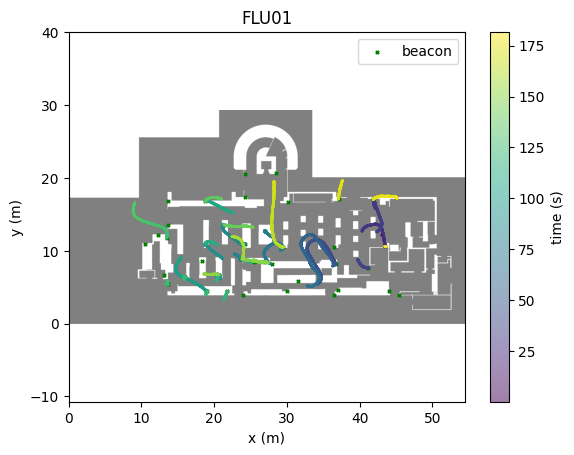

In [ ]:
floor_name = df_result["floor"][0] # get a floor name

plt.figure()
plt.axis("equal")

# plot map

# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01
xmax = map_dict[floor_name].shape[0] * dx # length of map along x axis
ymax = map_dict[floor_name].shape[1] * dy # length of map along y axis
plt.imshow(np.rot90(map_dict[floor_name]),
            extent=[0, xmax, 0, ymax],cmap="binary", alpha=0.5)

# plot beacons
beacons_in_floor = df_beacons[df_beacons["floorname"] == floor_name] # extract beacons in the designated floor
plt.scatter(beacons_in_floor.x, beacons_in_floor.y, c="g", label="beacon", marker="x", s=5)

cm = plt.scatter(df_result["x"], df_result["y"], c=df_result.ts, s=1, alpha=0.5)
plt.colorbar(cm, label="time (s)")
plt.legend()

plt.xlim(0, xmax)
plt.ylim(0, ymax)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title(floor_name)
plt.show()

### Visualize in an animation 

 99%|█████████▉| 180/181 [01:16<00:00,  2.34it/s]


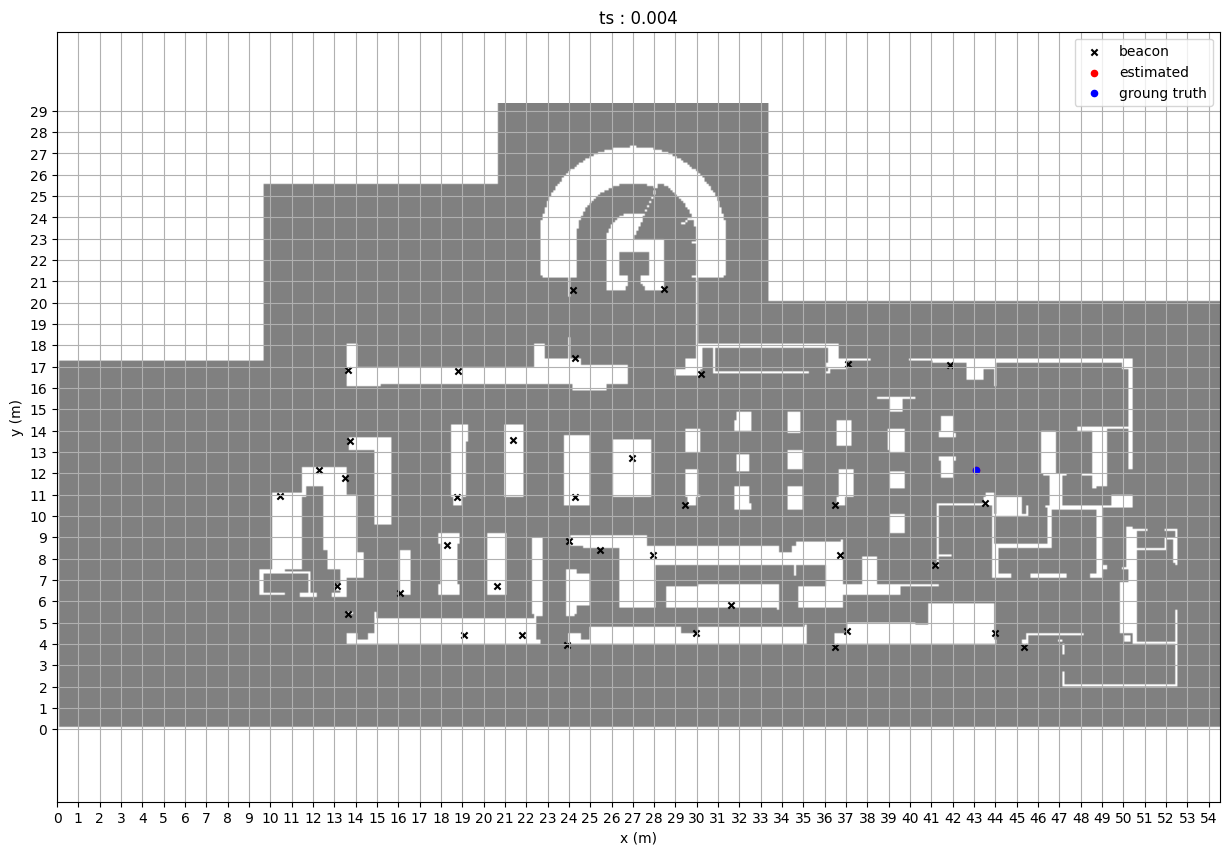

In [ ]:
import matplotlib.animation as animation
from tqdm import tqdm

decimation_rate = 100 # decimation of the animation frames. 100 means we plot movie every 100 samples (almost 1 sec).

# load ground truth
df_gt = pd.read_csv(GT_CSV_PATH)

# merge the localizatoin results
df_eval = pd.merge_asof(df_gt, df_result, left_on="%time", right_on="ts", suffixes=["_gt", "_est"], tolerance=0.02)

# show the animation of the result
fig = plt.figure(figsize=[15, 10])

def draw_result(idx):
    # plot floor map
    plt.clf()
    xmax = map_dict[floor_name].shape[0] * dx # length of map along x axis
    ymax = map_dict[floor_name].shape[1] * dy # length of map along y axis
    plt.imshow(np.rot90(map_dict[floor_name][::10, ::10]), # decimate map for faster plot
                extent=[0, xmax, 0, ymax],cmap="binary", alpha=0.5)
    plt.xticks(np.arange(0, xmax, 1))
    plt.yticks(np.arange(0, ymax, 1))
    
    # plot beacons
    beacons_in_floor = df_beacons[df_beacons["floorname"] == floor_name] # extract beacons in the designated floor
    plt.scatter(beacons_in_floor.x, beacons_in_floor.y, c="k", label="beacon", marker="x", s=20)
    
    # plot locations
    plt.scatter(df_eval.iloc[idx * decimation_rate]["x_est"], df_eval.iloc[idx * decimation_rate]["y_est"], c="r", s=20, alpha=1.0, label="estimated")
    plt.scatter(df_eval.iloc[idx * decimation_rate]["x_gt"], df_eval.iloc[idx * decimation_rate]["y_gt"], c="b", s=20, alpha=1.0, label="groung truth")
    
    plt.title("ts : {:.3f}".format(df_eval.iloc[idx * decimation_rate]["%time"]))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.axis("equal")
    plt.legend()
    plt.grid()
    
ani = animation.FuncAnimation(fig, draw_result, tqdm(np.arange(int(len(df_eval) / decimation_rate))), interval=100) # output whole results. 
from IPython.display import HTML 
HTML(ani.to_html5_video())

### Compare the results with ground truth quantatively

This is just an example of evaluation.
We will release full evaluation tool soon.

CE50 : 3.22 m
CE75 : 4.63 m


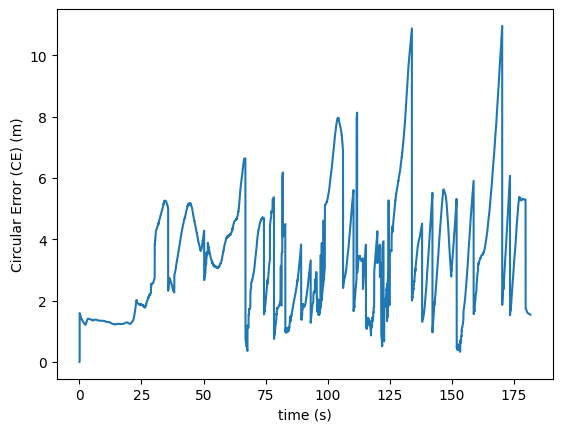

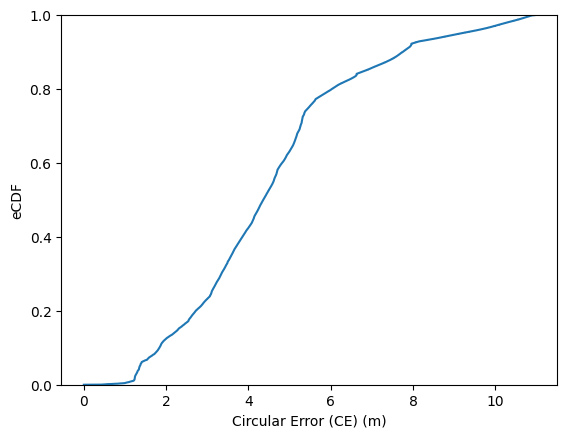

In [ ]:
df_eval_dropped = df_eval.dropna(subset=["x_gt", "y_gt", "x_est", "y_est"]) # Just in case some timestamps do not have corresponding estimations

ce = np.sqrt((df_eval_dropped["x_gt"] - df_eval_dropped["x_est"]) ** 2 + (df_eval_dropped["y_gt"] - df_eval_dropped["y_est"])  ** 2) # circular error (CE) of each time

print(f"CE50 : {np.percentile(ce, 50):.2f} m" )
print(f"CE75 : {np.percentile(ce, 75):.2f} m" )

ce_sorted = np.sort(ce)
ecdf = np.cumsum(ce_sorted) / np.sum(ce)

plt.plot(df_eval["%time"], ce)
plt.xlabel("time (s)")
plt.ylabel("Circular Error (CE) (m)")
plt.show()

plt.plot(ce_sorted, ecdf)
plt.xlabel("Circular Error (CE) (m)")
plt.ylabel("eCDF")
plt.ylim(0, 1)
plt.show()